In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/minimusicnet/audio-train.npy
/kaggle/input/minimusicnet/labels-test.npy
/kaggle/input/minimusicnet/audio-valid.npy
/kaggle/input/minimusicnet/labels-train.npy
/kaggle/input/minimusicnet/audio-test.npy
/kaggle/input/minimusicnet/labels-valid.npy


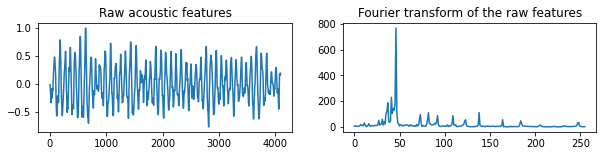

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Xtrain = np.load('../input/minimusicnet/audio-train.npy')
Ytrain = np.load('../input/minimusicnet/labels-train.npy')

fig, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].set_title('Raw acoustic features')
ax[0].plot(Xtrain[0])
ax[1].set_title('Fourier transform of the raw features')
ax[1].plot(np.abs(np.fft.rfft(Xtrain[0])[0:256])) # clip to 256 features for easier visualization

# https://github.com/prakashpandey9/Text-Classification-Pytorch/blob/master/load_data.py

In [3]:
# from sklearn.metrics import average_precision_score

# Xtest = np.load('../input/minimusicnet/audio-test.npy')
# Ytest = np.load('../input/minimusicnet/labels-test.npy')

# R = .001
# beta = np.dot(np.linalg.inv(np.dot(Xtrain.T,Xtrain) + R*np.eye(Xtrain.shape[1])),np.dot(Xtrain.T,Ytrain))

# print('Train AP:', round(average_precision_score(Ytrain, np.dot(Xtrain, beta), average='micro'), 2))
# print('Test AP:', round(average_precision_score(Ytest, np.dot(Xtest, beta), average='micro'), 2))

In [4]:
# Xtrainfft = np.abs(np.fft.rfft(Xtrain))
# Xtestfft = np.abs(np.fft.rfft(Xtest))

# R = .001
# beta = np.dot(np.linalg.inv(np.dot(Xtrainfft.T,Xtrainfft) + R*np.eye(Xtrainfft.shape[1])),np.dot(Xtrainfft.T,Ytrain))

# print('Train AP:', round(average_precision_score(Ytrain, np.dot(Xtrainfft, beta), average='micro'), 2))
# print('Test AP:', round(average_precision_score(Ytest, np.dot(Xtestfft, beta), average='micro'), 2))

In [5]:
Xtrain.shape

(62500, 4096)

In [6]:
import os
import sys
import torch
from torch.nn import functional as F
import numpy as np
from torchtext import data
from torchtext import datasets
from torch.utils.data import Dataset
import torch.utils.data as data_utl
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import average_precision_score

import warnings
warnings.filterwarnings('ignore')



Xtrain = np.load('../input/minimusicnet/audio-train.npy')
Ytrain = np.load('../input/minimusicnet/labels-train.npy')

Xtest = np.load('../input/minimusicnet/audio-test.npy')
Ytest = np.load('../input/minimusicnet/labels-test.npy')

Ytrain, Ytest = Ytrain[:,21:-26], Ytest[:,21:-26]

Xtrainfft = np.abs(np.fft.rfft(Xtrain))
Xtestfft = np.abs(np.fft.rfft(Xtest))


class MiniMusicNetDataSet(Dataset):
    """MusicNet dataset."""

    def __init__(self, clips, labels):
        
        self.clips = clips
        self.labels = labels

    def __len__(self):
        return self.clips.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        clip = torch.from_numpy(self.clips[idx]).float()
        label = self.labels[idx]
        sample = [clip, label]

        return sample

BATCH_SIZE = 64
max_freq_idx = 512 #clip the frequencies above 256Hz, as we don't have apreciable amplitude beyond that

Xtrainfft = Xtrainfft[:,:max_freq_idx]
Xtestfft = Xtestfft[:,:max_freq_idx]

train_clips, train_labels = Xtrainfft[:50000], Ytrain[:50000]
val_clips, val_labels = Xtrainfft[50000:], Ytrain[50000:]
test_clips, test_labels = Xtestfft, Ytest

train_dataset = MiniMusicNetDataSet(train_clips, train_labels)
val_dataset = MiniMusicNetDataSet(val_clips, val_labels)
test_dataset = MiniMusicNetDataSet(test_clips, test_labels)

BATCH_SIZE = 32
train_iterator = data_utl.DataLoader(train_dataset, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
val_iterator = data_utl.DataLoader(val_dataset, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)
test_iterator = data_utl.DataLoader(test_dataset, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

In [7]:
class LinearClassifier(nn.Module):
    def __init__(self, seq_len, output_size):
        super(LinearClassifier, self).__init__()
        
        self.seq_len = seq_len
        self.output_size = output_size
        self.dropout = nn.Dropout(0.5)
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(self.seq_len, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.output_size)
        )
        

    def forward(self, input_clips):
        logits = self.linear_relu_stack(input_clips.squeeze(-1))
        logits = self.dropout(logits)
        return logits

In [8]:
class LSTMClassifier(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size):
        super(LSTMClassifier, self).__init__()
        
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.dirs = 1
        self.dropout = 0.5
        self.bidirectional = False
        if self.bidirectional==True:
            self.dirs = 2 # 1 for bidirectional=False, else 2
        self.lstm = nn.LSTM(input_size=1, hidden_size= self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional = self.bidirectional, dropout = self.dropout)
        self.lin = nn.Linear(self.hidden_size, self.output_size)
        self.sfmx = nn.Softmax(dim = 1)

    def forward(self, input_clips):
        h_0 = Variable(torch.zeros(self.num_layers*self.dirs, input_clips.shape[0], self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.num_layers*self.dirs, input_clips.shape[0], self.hidden_size).cuda())
        output, (final_hidden_state, final_cell_state) = self.lstm(input_clips, (h_0, c_0))
        final_output = self.lin(final_hidden_state[-1]) # final_hidden_state.size() = (1, batch_size, hidden_size) & final_output.size() = (batch_size, output_size)
        final_output = self.sfmx(final_output)
        return final_output

In [9]:

# _*_ coding: utf-8 _*_


class AttentionModel(torch.nn.Module):
    def __init__(self, batch_size, output_size, hidden_size):
        super(AttentionModel, self).__init__()
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = 1
        self.dropout = 0.5
        
        self.dirs = 1
        self.bidirectional = False
        if self.bidirectional==True:
            self.dirs = 2 # 1 for bidirectional=False, else 2

        self.lstm = nn.LSTM(input_size=1, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, bidirectional = self.bidirectional, dropout = self.dropout)
        self.lin = nn.Linear(hidden_size, output_size)
        self.lsfmx = nn.Softmax(dim = 1)
        #self.attn_fc_layer = nn.Linear()
        
    def attention_net(self, lstm_output, final_state):

        hidden = final_state.squeeze(0)
        attn_weights = torch.bmm(lstm_output, hidden.unsqueeze(2)).squeeze(2)
        soft_attn_weights = F.softmax(attn_weights, 1)
        new_hidden_state = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return new_hidden_state

    def forward(self, input_clips):

        h_0 = Variable(torch.zeros(self.num_layers*self.dirs, input_clips.shape[0], self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(self.num_layers*self.dirs, input_clips.shape[0], self.hidden_size).cuda())

        output, (final_hidden_state, final_cell_state) = self.lstm(input_clips, (h_0, c_0)) # final_hidden_state.size() = (1, batch_size, hidden_size) 

        attn_output = self.attention_net(output, final_hidden_state)
        logits = self.lin(attn_output)
#         logits = self.lsfmx(logits)

        return logits

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size):
        super(SelfAttention, self).__init__()

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = 0.8
        
        self.dirs = 1
        self.bidirectional = True
        
        if self.bidirectional==True:
            self.dirs = 2 # 1 for bidirectional=False, else 2
            
        self.bilstm = nn.LSTM(input_size=1, 
                              hidden_size=self.hidden_size, 
                              batch_first=True, 
                              bidirectional = self.bidirectional, 
                              dropout=self.dropout)
        # We will use da = 350, r = 30 & penalization_coeff = 1 as per given in the self-attention original ICLR paper
        self.W_s1 = nn.Linear(2*self.hidden_size, 350)
        self.W_s2 = nn.Linear(350, 30)
        self.fc_layer = nn.Linear(30*2*hidden_size, 2000)
        self.lin = nn.Linear(2000, output_size)

    def attention_net(self, lstm_output):

        attn_weight_matrix = self.W_s2(F.tanh(self.W_s1(lstm_output)))
        attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
        attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

        return attn_weight_matrix

    def forward(self, input_clips):
#         print(input_clips.shape)
#         input_ = input_clips.permute(1, 0, 2)
        h_0 = Variable(torch.zeros(2, input_clips.shape[0], self.hidden_size).cuda())
        c_0 = Variable(torch.zeros(2, input_clips.shape[0], self.hidden_size).cuda())

        output, (h_n, c_n) = self.bilstm(input_clips, (h_0, c_0))
#         output = output.permute(1, 0, 2)
        # output.size() = (batch_size, num_seq, 2*hidden_size)
        # h_n.size() = (1, batch_size, hidden_size)
        # c_n.size() = (1, batch_size, hidden_size)
        attn_weight_matrix = self.attention_net(output)
        # attn_weight_matrix.size() = (batch_size, r, num_seq)
        # output.size() = (batch_size, num_seq, 2*hidden_size)
        hidden_matrix = torch.bmm(attn_weight_matrix, output)
        # hidden_matrix.size() = (batch_size, r, 2*hidden_size)
        # Let's now concatenate the hidden_matrix and connect it to the fully connected layer.
        fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
        logits = self.lin(fc_out)
        # logits.size() = (batch_size, output_size)

        return logits

In [11]:
class ConvClassifier2(nn.Module):
    def _init_(self, batch_size, output_size, hidden_size):
        super(ConvClassifier2, self)._init_()
        
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = 0
        
        self.conv1 = nn.Conv1d(1,1,65,padding=32)
        self.drop1 = nn.Dropout(self.dropout)
        self.relu1 = nn.GELU()
        
        self.conv2 = nn.Conv1d(1,1,65,padding=32)
        self.drop2 = nn.Dropout(self.dropout)
        self.relu2 = nn.GELU()
        
        self.conv3 = nn.Conv1d(1,1,65,padding=32)
        self.drop3 = nn.Dropout(self.dropout)
        self.relu3 = nn.GELU()
        
        self.conv4 = nn.Conv1d(1,1,65,padding=32)
        self.drop4 = nn.Dropout(self.dropout)
        self.relu4 = nn.GELU()
        
        self.conv5 = nn.Conv1d(1,1,65,padding=32)
        self.drop5 = nn.Dropout(self.dropout)
        self.relu5 = nn.GELU()
        
        self.conv6 = nn.Conv1d(1,1,65,padding=32)
        self.drop6 = nn.Dropout(self.dropout)
        self.relu6 = nn.GELU()
        
        self.conv7 = nn.Conv1d(1,1,65,padding=32)
        self.drop7 = nn.Dropout(self.dropout)
        self.relu7 = nn.GELU()
        
        self.conv8 = nn.Conv1d(1,1,65,padding=32)
        self.drop8 = nn.Dropout(self.dropout)
        self.relu8 = nn.GELU()
        
        self.conv9 = nn.Conv1d(1,1,65,padding=32)
        self.drop9 = nn.Dropout(self.dropout)
        self.relu9 = nn.GELU()
        
        self.conv10 = nn.Conv1d(1,1,65,padding=32)
        self.drop10 = nn.Dropout(self.dropout)
        self.relu10 = nn.GELU()
        
        self.conv11 = nn.Conv1d(1,1,65,padding=32)
        self.drop11 = nn.Dropout(self.dropout)
        self.relu11 = nn.GELU()
        
        self.conv12 = nn.Conv1d(1,1,65,padding=32)
        self.drop12 = nn.Dropout(self.dropout)
        self.relu12 = nn.GELU()
        
        self.lin = nn.Linear(512, self.output_size)

    def forward(self, input_clips):
        inter0 = input_clips.permute(0,2,1)
        inter1 = self.relu1(self.drop1(self.conv1(inter0)))
        inter2 = self.relu2(self.drop2(self.conv2(inter1)))
        inter3 = self.relu3(self.drop3(self.conv3(inter2))) + inter0
        inter4 = self.relu4(self.drop4(self.conv4(inter3)))
        inter5 = self.relu5(self.drop5(self.conv5(inter4)))
        inter6 = self.relu6(self.drop6(self.conv6(inter5))) + inter3
        inter7 = self.relu7(self.drop7(self.conv7(inter6)))
        inter8 = self.relu8(self.drop8(self.conv8(inter7)))
        inter9 = self.relu9(self.drop9(self.conv9(inter8))) + inter6
        inter10 = self.relu10(self.drop10(self.conv10(inter9)))
        inter11 = self.relu11(self.drop11(self.conv11(inter10)))
        inter12 = self.relu12(self.drop12(self.conv12(inter11)))
        
        final_output = self.lin(inter12).squeeze()
        return final_output

In [12]:
class ConvClassifier3(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size):
        super(ConvClassifier3, self).__init__()

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = 0.2

        self.conv1 = nn.Conv1d(1,1,129,padding=64)
        self.drop1 = nn.Dropout(self.dropout)
        self.tanh = nn.Tanh()

        self.lin = nn.Linear(256, self.output_size)

        
    def forward(self, input_clips):
        inter0 = input_clips.permute(0,2,1)
        inter1 = self.tanh(self.drop1(self.conv1(inter0)))

        final_output = self.lin(inter1).squeeze()
        return final_output

In [13]:
class ConvClassifier3(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size):
        super(ConvClassifier3, self).__init__()

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.dropout = 0
        
        self.conv1 = nn.Conv1d(1,1,65,padding=32)
        self.drop1 = nn.Dropout(self.dropout)
        self.relu1 = nn.GELU()
        
        self.conv2 = nn.Conv1d(1,1,65,padding=32)
        self.drop2 = nn.Dropout(self.dropout)
        self.relu2 = nn.GELU()
        
        self.conv3 = nn.Conv1d(1,1,65,padding=32)
        self.drop3 = nn.Dropout(self.dropout)
        self.relu3 = nn.GELU()
        
        self.conv4 = nn.Conv1d(1,1,65,padding=32)
        self.drop4 = nn.Dropout(self.dropout)
        self.relu4 = nn.GELU()
        
        self.conv5 = nn.Conv1d(1,1,65,padding=32)
        self.drop5 = nn.Dropout(self.dropout)
        self.relu5 = nn.GELU()
        
        self.conv6 = nn.Conv1d(1,1,65,padding=32)
        self.drop6 = nn.Dropout(self.dropout)
        self.relu6 = nn.GELU()
        
        self.conv7 = nn.Conv1d(1,1,65,padding=32)
        self.drop7 = nn.Dropout(self.dropout)
        self.relu7 = nn.GELU()
        
        self.conv8 = nn.Conv1d(1,1,65,padding=32)
        self.drop8 = nn.Dropout(self.dropout)
        self.relu8 = nn.GELU()
        
        self.conv9 = nn.Conv1d(1,1,65,padding=32)
        self.drop9 = nn.Dropout(self.dropout)
        self.relu9 = nn.GELU()
        
        self.conv10 = nn.Conv1d(1,1,65,padding=32)
        self.drop10 = nn.Dropout(self.dropout)
        self.relu10 = nn.GELU()
        
        self.conv11 = nn.Conv1d(1,1,65,padding=32)
        self.drop11 = nn.Dropout(self.dropout)
        self.relu11 = nn.GELU()
        
        self.conv12 = nn.Conv1d(1,1,65,padding=32)
        self.drop12 = nn.Dropout(self.dropout)
        self.relu12 = nn.GELU()
        
        self.lin = nn.Linear(512, self.output_size)

        
    def forward(self, input_clips):
        inter0 = input_clips.permute(0,2,1)
        inter1 = self.relu1(self.drop1(self.conv1(inter0)))
        inter2 = self.relu2(self.drop2(self.conv2(inter1)))
        inter3 = self.relu3(self.drop3(self.conv3(inter2))) + inter0
        inter4 = self.relu4(self.drop4(self.conv4(inter3)))
        inter5 = self.relu5(self.drop5(self.conv5(inter4)))
        inter6 = self.relu6(self.drop6(self.conv6(inter5))) + inter3
        inter7 = self.relu7(self.drop7(self.conv7(inter6)))
        inter8 = self.relu8(self.drop8(self.conv8(inter7)))
        inter9 = self.relu9(self.drop9(self.conv9(inter8))) + inter6
        inter10 = self.relu10(self.drop10(self.conv10(inter9)))
        inter11 = self.relu11(self.drop11(self.conv11(inter10)))
        inter12 = self.relu12(self.drop12(self.conv12(inter11)))
        
        final_output = self.lin(inter12).squeeze()
        return final_output

In [14]:
import os
import time
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import torch.nn as nn


def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)
    
def train_model(model, train_iter, epoch, lr=1e-3):
    total_epoch_loss = 0
    total_epoch_psc = 0
    model.cuda()
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)
    steps = 0
    model.train()
    for idx, batch in enumerate(train_iter):
        clip = batch[0].unsqueeze(-1)
        target = batch[1]
        target = torch.autograd.Variable(target).long()
        if torch.cuda.is_available():
            clip = clip.cuda()
            target = target.cuda()
        
        optim.zero_grad()
        prediction = model(clip)
        loss = loss_fn(prediction, target.float())
#         num_corrects = (torch.max(prediction, 1)[1].view(target.size()).data == target.data).float().sum()
#         acc = 100.0 * num_corrects/len(batch)
        loss.backward()
#         clip_gradient(model, 1e-1)
        optim.step()
        steps += 1
        acc_dum = 0
        avgp = average_precision_score(batch[1].detach().cpu().numpy().flatten(), prediction.detach().cpu().numpy().flatten(), average = 'weighted')
        if steps % 100 == 0:
            print (f'Epoch: {epoch+1}, Idx: {idx+1}, Training Loss: {loss.item():.4f}, Training Precision Score: {avgp: .2f}%')
        
        total_epoch_loss += loss.item()
        total_epoch_psc += avgp
        
    return total_epoch_loss/len(train_iter), total_epoch_psc/len(train_iter)

def eval_model(model, val_iter):
    total_epoch_loss = 0
    total_epoch_psc = 0
    model.eval()
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            clip = batch[0].unsqueeze(-1)
            target = batch[1]
            target = torch.autograd.Variable(target).long()
            if torch.cuda.is_available():
                clip = clip.cuda()
                target = target.cuda()
            prediction = model(clip)
            loss = loss_fn(prediction, target.float())
            avgp = average_precision_score(batch[1].detach().cpu().numpy().flatten(), prediction.detach().cpu().numpy().flatten(), average = 'weighted')
            total_epoch_loss += loss.item()
            total_epoch_psc += avgp

    return total_epoch_loss/len(val_iter), total_epoch_psc/len(val_iter)


learning_rate = 1e-3
batch_size = 32
output_size = 81
hidden_size = 1024
EPOCHS = 10

loss_fn = nn.BCEWithLogitsLoss()

# model = LinearClassifier(max_freq_idx, output_size)

# model = LSTMClassifier(batch_size, output_size, hidden_size)
# model = AttentionModel(batch_size, output_size, hidden_size)
# model = SelfAttention(batch_size, output_size, hidden_size)
model = ConvClassifier3(batch_size, output_size, hidden_size)

tl = []
tp = []
vl = []
vp = []

learning_rate = 1e-3
batch_size = 32
output_size = 81
hidden_size = 1024
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_iterator, epoch, lr=learning_rate)
    val_loss, val_acc = eval_model(model, val_iterator)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train AvgPrScore: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val AvgPrScore: {val_acc:.2f}%')
    
    tl.append(train_loss)
    tp.append(train_acc)
    vl.append(val_loss)
    vp.append(val_acc)

Epoch: 1, Idx: 100, Training Loss: 0.1266, Training Precision Score:  0.20%
Epoch: 1, Idx: 200, Training Loss: 0.1039, Training Precision Score:  0.50%
Epoch: 1, Idx: 300, Training Loss: 0.1042, Training Precision Score:  0.38%
Epoch: 1, Idx: 400, Training Loss: 0.1079, Training Precision Score:  0.46%
Epoch: 1, Idx: 500, Training Loss: 0.0841, Training Precision Score:  0.56%
Epoch: 1, Idx: 600, Training Loss: 0.0846, Training Precision Score:  0.45%
Epoch: 1, Idx: 700, Training Loss: 0.0826, Training Precision Score:  0.64%
Epoch: 1, Idx: 800, Training Loss: 0.0902, Training Precision Score:  0.53%
Epoch: 1, Idx: 900, Training Loss: 0.0759, Training Precision Score:  0.48%
Epoch: 1, Idx: 1000, Training Loss: 0.0884, Training Precision Score:  0.48%
Epoch: 1, Idx: 1100, Training Loss: 0.0893, Training Precision Score:  0.49%
Epoch: 1, Idx: 1200, Training Loss: 0.0963, Training Precision Score:  0.51%
Epoch: 1, Idx: 1300, Training Loss: 0.0967, Training Precision Score:  0.49%
Epoch: 1

In [15]:
learning_rate = 5e-4
batch_size = 32
output_size = 81
hidden_size = 1024
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_iterator, epoch, lr=learning_rate)
    val_loss, val_acc = eval_model(model, val_iterator)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train AvgPrScore: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val AvgPrScore: {val_acc:.2f}%')
    
    tl.append(train_loss)
    tp.append(train_acc)
    vl.append(val_loss)
    vp.append(val_acc)

Epoch: 1, Idx: 100, Training Loss: 0.0715, Training Precision Score:  0.69%
Epoch: 1, Idx: 200, Training Loss: 0.0765, Training Precision Score:  0.73%
Epoch: 1, Idx: 300, Training Loss: 0.0762, Training Precision Score:  0.65%
Epoch: 1, Idx: 400, Training Loss: 0.0828, Training Precision Score:  0.58%
Epoch: 1, Idx: 500, Training Loss: 0.0778, Training Precision Score:  0.66%
Epoch: 1, Idx: 600, Training Loss: 0.0979, Training Precision Score:  0.53%
Epoch: 1, Idx: 700, Training Loss: 0.0854, Training Precision Score:  0.67%
Epoch: 1, Idx: 800, Training Loss: 0.0947, Training Precision Score:  0.55%
Epoch: 1, Idx: 900, Training Loss: 0.0769, Training Precision Score:  0.68%
Epoch: 1, Idx: 1000, Training Loss: 0.0686, Training Precision Score:  0.66%
Epoch: 1, Idx: 1100, Training Loss: 0.0771, Training Precision Score:  0.62%
Epoch: 1, Idx: 1200, Training Loss: 0.0755, Training Precision Score:  0.63%
Epoch: 1, Idx: 1300, Training Loss: 0.0701, Training Precision Score:  0.67%
Epoch: 1

In [16]:
learning_rate = 1e-4
batch_size = 32
output_size = 81
hidden_size = 1024
EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss, train_acc = train_model(model, train_iterator, epoch, lr=learning_rate)
    val_loss, val_acc = eval_model(model, val_iterator)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train AvgPrScore: {train_acc:.2f}%, Val. Loss: {val_loss:3f}, Val AvgPrScore: {val_acc:.2f}%')
    
    tl.append(train_loss)
    tp.append(train_acc)
    vl.append(val_loss)
    vp.append(val_acc)

Epoch: 1, Idx: 100, Training Loss: 0.0540, Training Precision Score:  0.71%
Epoch: 1, Idx: 200, Training Loss: 0.0761, Training Precision Score:  0.67%
Epoch: 1, Idx: 300, Training Loss: 0.0748, Training Precision Score:  0.65%
Epoch: 1, Idx: 400, Training Loss: 0.0636, Training Precision Score:  0.65%
Epoch: 1, Idx: 500, Training Loss: 0.0753, Training Precision Score:  0.70%
Epoch: 1, Idx: 600, Training Loss: 0.0681, Training Precision Score:  0.67%
Epoch: 1, Idx: 700, Training Loss: 0.0594, Training Precision Score:  0.66%
Epoch: 1, Idx: 800, Training Loss: 0.0673, Training Precision Score:  0.73%
Epoch: 1, Idx: 900, Training Loss: 0.0618, Training Precision Score:  0.69%
Epoch: 1, Idx: 1000, Training Loss: 0.0540, Training Precision Score:  0.70%
Epoch: 1, Idx: 1100, Training Loss: 0.0809, Training Precision Score:  0.45%
Epoch: 1, Idx: 1200, Training Loss: 0.0808, Training Precision Score:  0.60%
Epoch: 1, Idx: 1300, Training Loss: 0.0774, Training Precision Score:  0.74%
Epoch: 1

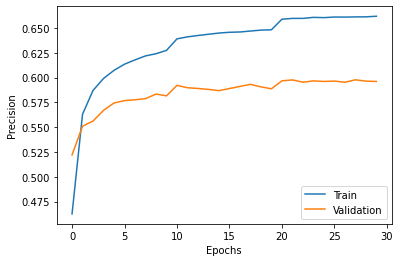

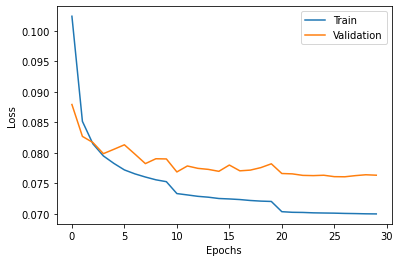

<Figure size 432x288 with 0 Axes>

In [17]:
# Plot avg precision
plt.plot(tp)
plt.plot(vp)
# plt.title('1-Layer Conv: Precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
plt.savefig('conv_1layer_precision')

# Plot loss
plt.plot(tl)
plt.plot(vl)
# plt.title('1-Layer Conv: Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.savefig('conv_1layer_loss')

In [18]:
import scipy
from sklearn.metrics import accuracy_score

torch.cuda.empty_cache() 
clips = train_clips[:10000]
targets = train_labels[:10000]

model.eval()
with torch.no_grad():
    if torch.cuda.is_available():
        clips = torch.tensor(clips).cuda()
        clips = clips.unsqueeze(-1).float()
        targets = torch.tensor(targets).cuda()
        predictions = model(clips)
Y_test = targets

def thr_to_accuracy(thr, Y_test, predictions):
    return -accuracy_score(Y_test.detach().cpu().numpy(), np.array(predictions.detach().cpu().numpy() >thr, dtype=np.int))

best_thr = scipy.optimize.fmin(thr_to_accuracy, args=(Y_test, predictions), x0=0.5)
print(best_thr)

accuracy_thr = accuracy_score(Y_test.detach().cpu().numpy(), np.array(predictions.detach().cpu().numpy() >best_thr, dtype=np.int))
print(accuracy_thr)

Optimization terminated successfully.
         Current function value: -0.176300
         Iterations: 17
         Function evaluations: 39
[-0.109375]
0.1763


Actual note indices: [36 44 54]
Predicted note indices: [44]


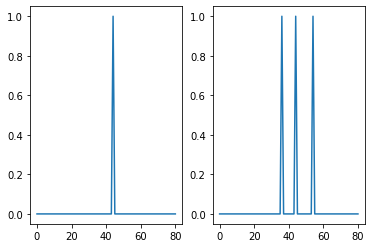

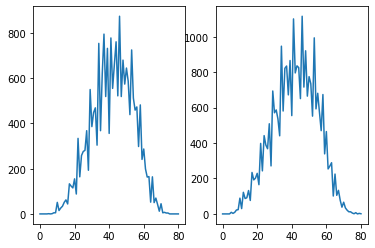

In [19]:
torch.cuda.empty_cache() 
clips = test_clips
targets = test_labels

model.eval()
with torch.no_grad():
    if torch.cuda.is_available():
        clips = torch.tensor(clips).cuda()
        clips = clips.unsqueeze(-1).float()
        targets = torch.tensor(targets).cuda()
        predictions = model(clips)
Y_test = targets

t = 400
pred = np.array(predictions.detach().cpu().numpy() >best_thr[0], dtype=np.int)
actual = targets.detach().cpu().numpy()
print("Actual note indices: {}".format(np.where(actual[t]==1)[0]))
print("Predicted note indices: {}".format(np.where(pred[t]==1)[0]))
f,ax = plt.subplots(1,2)
ax[0].plot(pred[t])
ax[1].plot(actual[t])
f,ax = plt.subplots(1,2)
ax[0].plot(np.sum(pred, axis = 0))
ax[1].plot(np.sum(actual, axis = 0))

In [20]:
# #Source: https://stackoverflow.com/questions/52093388/how-to-choose-optimal-threshold-for-class-probabilities

# class proxyModel():
#     def __init__(self, origin_model):
#         self.origin_model = origin_model

#     def predict_proba(self, ori_proba, threshold_list=None):
#         # get origin probability
# #         ori_proba = self.origin_model.predict_proba(x)
# #         ori_proba = self.origin_model(x).detach().cpu().numpy()
        

#         # set default threshold
#         if threshold_list is None:
#             threshold_list = np.full(ori_proba[0].shape, 1)
        
#         # get the output shape of threshold_list
#         output_shape = np.array(threshold_list).shape

#         # element-wise divide by the threshold of each classes
#         new_proba = np.divide(ori_proba, threshold_list)

#         # calculate the norm (sum of new probability of each classes)
#         norm = np.linalg.norm(new_proba, ord=1, axis=1)

#         # reshape the norm
#         norm = np.broadcast_to(np.array([norm]).T, (norm.shape[0],output_shape[0]))

#         # renormalize the new probability
#         new_proba = np.divide(new_proba, norm)

#         return new_proba

#     def predict(self, x, threshold_list=None):
#         preds = np.argmax(self.predict_proba(x, threshold_list), axis=1)
#         return preds

# def scoreFunc(model, pred_prob, y_true, threshold_list):
# #     y_pred = model.predict(X, threshold_list=threshold_list)
#     y_pred_proba = model.predict_proba(pred_prob, threshold_list=threshold_list)

#     ###### metrics ######
#     from sklearn.metrics import accuracy_score
#     from sklearn.metrics import roc_auc_score
#     from sklearn.metrics import average_precision_score
#     from sklearn.metrics import f1_score

#     y_true = y_true.detach().cpu().numpy()
# #     accuracy = accuracy_score(y_true, y_pred)
# #     roc_auc = roc_auc_score(y_true, y_pred_proba, average='macro')
# #     print(y_true.dtype())
#     pr_auc = average_precision_score(y_true, y_pred_proba, average='macro')
# #     f1_value = f1_score(y_true, y_pred, average='macro')
#     return pr_auc

# def weighted_score_with_threshold(threshold, model, pred_prob, Y_test, metrics='accuracy', delta=5e-5):
#     # if the sum of thresholds were not between 1+delta and 1-delta, 
#     # return infinity (just for reduce the search space of the minimizaiton algorithm, 
#     # because the sum of thresholds should be as close to 1 as possible).
# #     print(threshold)
#     threshold_sum = np.sum(threshold)
# #     print(threshold_sum)
# #     print(threshold)

#     if threshold_sum > 1+delta:
#         return np.inf

#     if threshold_sum < 1-delta:
#         return np.inf

#     # to avoid objective function jump into nan solution
#     if np.isnan(threshold_sum):
#         print("threshold_sum is nan")
#         return np.inf

#     # renormalize: the sum of threshold should be 1
#     normalized_threshold = threshold/threshold_sum

#     # calculate scores based on thresholds
#     # suppose it'll return 4 scores in a tuple: (accuracy, roc_auc, pr_auc, f1)
#     scores = scoreFunc(model, pred_prob, Y_test, threshold_list=normalized_threshold)
# #     print(scores)

# #     scores = np.array(scores)
# #     weight = np.array([1])

# #     Give the metric you want to maximize a bigger weight:
# #     if metrics == 'accuracy':
# #         weight = np.array([10,1,1,1])
# #     if metrics == 'roc_auc':
# #         weight = np.array([10,1])
# #     elif metrics == 'pr_auc':
# #         weight = np.array([1,10])
# #     elif metrics == 'f1':
# #         weight = np.array([1,1,1,10])
# #     elif 'all':
# #         weight = np.array([1,1,1,1])

# #     return negatitive weighted sum (because you want to maximize the sum, 
# #     it's equivalent to minimize the negative sum)
# #     return -np.dot(weight, scores)
# #     print("***")
# #     print(scores)
#     return -scores


# from scipy import optimize

# #############################
# torch.cuda.empty_cache() 
# clips = train_clips[:10000]
# targets = train_labels[:10000]

# model.eval()
# with torch.no_grad():
#     if torch.cuda.is_available():
#         clips = torch.tensor(clips).cuda()
#         clips = clips.unsqueeze(-1).float()
#         targets = torch.tensor(targets).cuda()
#         predictions = model(clips)
#         preds_sfmx = nn.Softmax(dim=1)(predictions)
#         print(predictions.shape)
# #############################
# pred_prob = preds_sfmx.detach().cpu().numpy()
# assert np.sum(pred_prob[0])==1
# Y_test = targets

# output_class_num = targets.shape[1]
# bounds = optimize.Bounds([1e-5]*output_class_num,[1]*output_class_num)
# # bounds = [(1e-5,1)]*output_class_num
# # print(bounds)

# pmodel = proxyModel(model)
# # print(pmodel.predict_proba(X_test))

# def constr_f(threshold):
#     return np.sum(threshold)

# nlc = optimize.NonlinearConstraint(constr_f, 1-5e-5, 1+5e-5)

# result = optimize.differential_evolution(weighted_score_with_threshold, bounds = bounds, args=(pmodel, pred_prob, Y_test, 'pr_auc'), disp = True, constraints=(nlc), maxiter=20)

# # # calculate threshold
# threshold = result.x/np.sum(result.x)
# print(threshold)

# # # print the optimized score
# # print(scoreFunc(pmodel, pred_prob, Y_test, threshold_list=threshold))

In [21]:
# from scipy.optimize import NonlinearConstraint, Bounds, rosen
# def constr_f(y):
#     return np.sum(y)

# # the sum of x[0] and x[1] must be less than 1.9
# nlc = NonlinearConstraint(constr_f, -np.inf, 5)
# # specify limits using a `Bounds` object.
# bounds = Bounds([0., 0.], [2., 2.])
# result = optimize.differential_evolution(rosen, bounds, constraints=(nlc),
#                                 seed=1)
# result.x